<a href="https://colab.research.google.com/github/shahriariit/Short-Term-Forecasting-BD/blob/main/COVID_19_Bangladesh_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
pip install wget

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from pandas import DatetimeIndex
from pandas import Timestamp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time
from sklearn import svm
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import max_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import mean_tweedie_deviance
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import plotly.offline as py 
import plotly.graph_objects as go
import plotly.express as px
pd.set_option('display.float_format', lambda x: '%.6f' % x)

import wget

In [ ]:
! rm *.csv


urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv']


for url in urls:
    filename = wget.download(url)


conf_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recv_df = pd.read_csv('time_series_covid19_recovered_global.csv')   

dates = conf_df.columns[4:]

conf_df_long = conf_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], value_vars=dates, var_name='Date', value_name='Confirmed')
deaths_df_long = deaths_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], value_vars=dates, var_name='Date', value_name='Deaths')
recv_df_long = recv_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], value_vars=dates, var_name='Date', value_name='Recovered')

In [ ]:
covid = pd.concat([conf_df_long, deaths_df_long['Deaths'],recv_df_long['Recovered']], axis=1, sort=False)
covid["Date"]=pd.to_datetime(covid["Date"])

In [ ]:
datewise=covid.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise.tail()

,Confirmed,Recovered,Deaths
Date,,,
2021-04-01,129607651,0.000000,2827554
2021-04-02,130236504,0.000000,2837709
2021-04-03,130769607,0.000000,2846129
2021-04-04,131321563,0.000000,2852987
2021-04-05,131813449,0.000000,2860549


In [ ]:
bd_data=covid[covid["Country/Region"]=="Bangladesh"]
datewise_bd=bd_data.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
print(datewise_bd.iloc[-1])
print("Total Active Cases: ",datewise_bd["Confirmed"].iloc[-1]-datewise_bd["Recovered"].iloc[-1]-datewise_bd["Deaths"].iloc[-1])
print("Total Closed Cases: ",datewise_bd["Recovered"].iloc[-1]+datewise_bd["Deaths"].iloc[-1])

Confirmed   644439.000000
Recovered        0.000000
Deaths        9318.000000
Name: 2021-04-05 00:00:00, dtype: float64
Total Active Cases:  635121.0
Total Closed Cases:  9318.0


In [ ]:

datewise_bd=datewise_bd[284:309]


In [ ]:
datewise_bd["Days Since"]=datewise_bd.index-datewise_bd.index[0]
datewise_bd["Days Since"]=datewise_bd["Days Since"].dt.days

train_ml=datewise_bd.iloc[:int(datewise_bd.shape[0]*0.85)]
valid_ml=datewise_bd.iloc[int(datewise_bd.shape[0]*0.85):]

In [ ]:
valid_ml

,Confirmed,Recovered,Deaths,Days Since
Date,,,,
2020-11-22,447341,911113.000000,6388,21
2020-11-23,449760,15950.000000,6416,22
2020-11-24,451990,0.000000,6448,23
2020-11-25,454146,163048.000000,6487,24


In [ ]:
day=8
poly_degree_pr=3
svm_degree=5
poly_degree_polymlp=3

In [ ]:
bayesian_poly = PolynomialFeatures(degree=4)
bayesian_poly_train_ml = bayesian_poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
bayesian_poly_valid_ml = bayesian_poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
bayesian_poly_datewise_ml = bayesian_poly.fit_transform(np.array(datewise_bd["Days Since"]).reshape(-1,1))

In [ ]:
#model_train=datewise_bd.iloc[:int(datewise_bd.shape[0]*0.80)]
#valid=datewise_bd.iloc[int(datewise_bd.shape[0]*0.80):]

#model_train = model_train.fillna(method='ffill')
#valid = valid.fillna(method='ffill')

In [ ]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

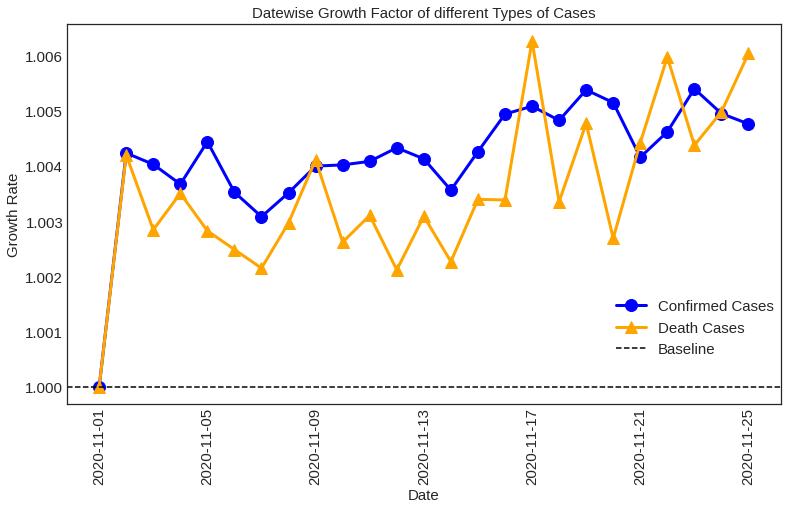

In [ ]:
bd_increase_confirm=[]
bd_increase_deaths=[]

for i in range(datewise_bd.shape[0]-1):
    bd_increase_confirm.append(((datewise_bd["Confirmed"].iloc[i+1])/datewise_bd["Confirmed"].iloc[i]))
    bd_increase_deaths.append(((datewise_bd["Deaths"].iloc[i+1])/datewise_bd["Deaths"].iloc[i]))
bd_increase_confirm.insert(0,1)
bd_increase_deaths.insert(0,1)

gplot=plt.figure(figsize=(12.8,7))
plt.style.use('seaborn-white')
plt.plot(datewise_bd.index,bd_increase_confirm,label="Confirmed Cases",color='blue',linewidth=3, marker='o', markerfacecolor='blue', markersize=12)
plt.plot(datewise_bd.index,bd_increase_deaths,label="Death Cases",color='orange',linewidth=3, marker='^', markerfacecolor='orange', markersize=12)
plt.axhline(1,linestyle='--',color="black",label="Baseline")

plt.xticks(rotation=90)
plt.title("Datewise Growth Factor of different Types of Cases")

plt.xlabel("Date")
plt.ylabel("Growth Rate")

plt.legend(loc='center left', bbox_to_anchor=(0.75, 0.2))

In [ ]:
g_fig = px.line(datewise_bd, x=datewise_bd.index, y=bd_increase_confirm)
g_fig.add_scatter(x=datewise_bd.index, y=bd_increase_deaths) 
g_fig.show()

In [ ]:
def plot_result(data_d,new_date_time_index, forecast, gcolor, gcase, gtitle):
    
    plt.style.use('seaborn-white')
    plt.plot(data_d,label="Actual "+gcase,color=gcolor, linestyle='solid', linewidth = 3, marker='o', markerfacecolor=gcolor, markersize=12)
    plt.plot(new_date_time_index,forecast,label="Predicted "+gcase,color='black', linestyle='solid', linewidth = 3, marker='*', markerfacecolor='black', markersize=12)
    #plt.xlabel('Date Time')
    #plt.ylabel(gcase)
    #plt.title(gtitle)

In [ ]:
def new_forecast(prediction,new_prediction,new_date):
    
    forecast=np.concatenate((prediction,new_prediction))

    new_ar = []

    for single_timestamp in datewise_bd.index:
        new_ar.append(pd.to_datetime(single_timestamp))

    for single_timestamp in new_date:
        new_ar.append(pd.to_datetime(single_timestamp))

    new_date_time_index = DatetimeIndex(new_ar, dtype='datetime64[ns]', name='Date', freq=None)

    return (forecast,new_date_time_index)

In [ ]:
def date_generation(n):
    
     new_date=[]
     new_prediction_holt=[]

     for i in range(1,n):
        new_date.append(datewise_bd.index[-1]+timedelta(days=i))

     new_ar = []
  
     for single_timestamp in new_date:
        new_ar.append(pd.to_datetime(single_timestamp))

     new_date_time_index = DatetimeIndex(new_ar, dtype='datetime64[ns]', name='Date', freq=None)

     return (new_date_time_index)

In [ ]:
def result_head_conf(x):
    df1=datewise_bd["Confirmed"].head()
    df2=pd.DataFrame(x).head()
    frames1=[df1,df2]
    result = pd.concat(frames1)
    print(result)  

def result__conf(x):
    df1=datewise_bd["Confirmed"].head()
    df2=pd.DataFrame(x).head()
    frames1=[df1,df2]
    result = pd.concat(frames1)
    print(result) 

In [ ]:
def eval_reg(y,y_p):
  
   # print("Varience Score for Polynomial Regression:", explained_variance_score(y,y_p,multioutput='uniform_average'))
   # print("Max-Error for Polynomial Regression:", max_error(y,y_p))
   # print("Root Mean Square Error for Polynomial Regression: ",np.sqrt(mean_squared_error(y,y_p)))
    print("Mean Absolute Error: ",mean_absolute_error(y,y_p))
   # print("Median Absolute Error for Polynomial Regression:", median_absolute_error(y,y_p))
    print("R2-Squared:", r2_score(y,y_p))
   # print("Mean Square Log Error for Polynomial Regression:", mean_squared_log_error(y,y_p))
   # print("Mean Poisson Deviance for Polynomial Regression:", mean_poisson_deviance(y,y_p))
   # print("Mean Gamma Deviance for Polynomial Regression:", mean_gamma_deviance(y,y_p))
   # print("Mean Tweedie Deviance for Polynomial Regression:", mean_tweedie_deviance(y,y_p))

In [ ]:
def  interactive_graph(index_c,forecast_c, index_d,forecast_d):   
     
     fig = px.line(datewise_bd, x=index_c, y=forecast_c)
     fig.add_scatter(x=index_c, y=datewise_bd['Confirmed']) 

     fig1 = px.line(datewise_bd, x=index_d, y=forecast_d)
     fig1.add_scatter(x=index_d, y=datewise_bd['Deaths']) 

     fig.show()
     fig1.show()

In [ ]:
def linearRegression_covid_19(train_d,valid_d,data_d,case):

    model_scores=[]
   
    lin_reg=LinearRegression(normalize=True)
    lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_d).reshape(-1,1))

    print(case)

    prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
    #print("Valid: ",prediction_valid_linreg)
    model_scores.append(np.sqrt(mean_squared_error(valid_d,prediction_valid_linreg)))
    print("RMSE for Linear Regression: ",model_scores)
    
    eval_reg(valid_d,prediction_valid_linreg)
    
    
    prediction_linreg=lin_reg.predict(np.array(datewise_bd["Days Since"]).reshape(-1,1))
    #print("All: ",prediction_linreg[21:25])
    
    #model_scores1=[]
    #model_scores1.append(np.sqrt(mean_squared_error(valid_d,prediction_linreg[21:25])))
    #print("RMSE for LR: ", model_scores1) 



    new_date=[]
    new_prediction_lr=[]

    for i in range(1,day):
       new_date.append(datewise_bd.index[-1]+timedelta(days=i))
       new_prediction_lr.append(lin_reg.predict(np.array(datewise_bd["Days Since"].max()+i).reshape(-1,1))[0])

    forecast_lr, new_date_time_index =new_forecast(prediction_linreg,new_prediction_lr,new_date)
 
    #plot_result(data_d,new_date_time_index, forecast_lr,'blue', case,'Linear Regression Prediction')

    return (forecast_lr, new_date_time_index,model_scores)



In [ ]:
print(valid_ml['Days Since'])

Date
2020-11-22    21
2020-11-23    22
2020-11-24    23
2020-11-25    24
Name: Days Since, dtype: int64


Confirmed Cases
RMSE for Linear Regression:  [2563.0521119750433]
Mean Absolute Error:  2502.356060606049
R2-Squared: -0.024132655831817118
Death Cases
RMSE for Linear Regression:  [58.769627727206796]
Mean Absolute Error:  56.8019480519481
R2-Squared: -1.5383265027381188


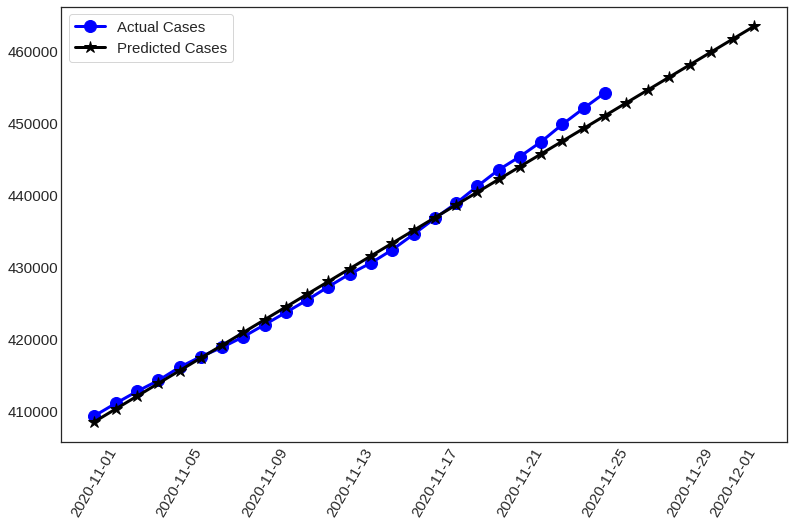

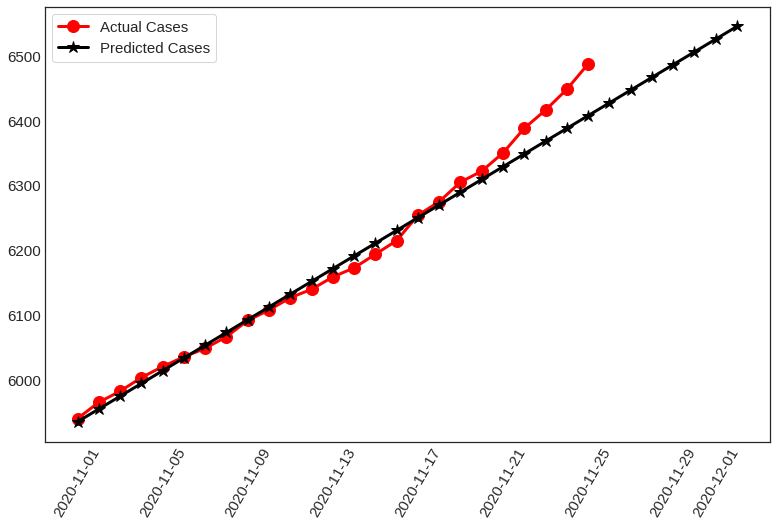

Execution Time 0.49984499600003574


In [ ]:
t1 = time.process_time()

forecast_lr_c, new_date_time_index_c, model_score_lm_c = linearRegression_covid_19(train_ml["Confirmed"],valid_ml["Confirmed"],datewise_bd["Confirmed"],'Confirmed Cases')
forecast_lr_d, new_date_time_index_d, model_score_lm_d = linearRegression_covid_19(train_ml["Deaths"],valid_ml["Deaths"],datewise_bd["Deaths"],'Death Cases')


plt.figure(figsize=(13,8))
plot_result(datewise_bd["Confirmed"],new_date_time_index_c, forecast_lr_c,'blue','Cases', 'Linear Regression')
#plot_result(datewise_bd["Deaths"],new_date_time_index_d, forecast_lr_d,'red','Death Cases', 'Linear Regression')
plt.xticks(rotation=60)
plt.legend(frameon=True) 
plt.show()

plt.figure(figsize=(13,8))
#plot_result(datewise_bd["Confirmed"],new_date_time_index_c, forecast_lr_c,'blue','Confirmed Cases', 'Linear Regression')
plot_result(datewise_bd["Deaths"],new_date_time_index_d, forecast_lr_d,'red','Cases', 'Linear Regression')
plt.xticks(rotation=60)
plt.legend(frameon=True) 
plt.show() 

elapsed_time_lr = time.process_time() - t1

print("Execution Time", elapsed_time_lr)

In [ ]:
interactive_graph(new_date_time_index_c,forecast_lr_c,new_date_time_index_d,forecast_lr_d)

In [ ]:
def PolyRegression_covid_19(number_of_degree,train_d,valid_d,data_d,case):

    poly = PolynomialFeatures(degree=number_of_degree)
    poly_train_ml = poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
    poly_valid_ml = poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
    poly_datewise_ml = poly.fit_transform(np.array(datewise_bd["Days Since"]).reshape(-1,1))
   
    model_scores=[]

    lin_reg=LinearRegression(normalize=True)
    lin_reg.fit(poly_train_ml,np.array(train_d).reshape(-1,1))

    print(case)
    
    prediction_valid_linreg=lin_reg.predict(poly_valid_ml)
    model_scores.append(np.sqrt(mean_squared_error(valid_d,prediction_valid_linreg)))
    print("RMSE for Polynomial Regression: ",model_scores)

    eval_reg(valid_d,prediction_valid_linreg) 

    prediction_linreg=lin_reg.predict(poly_datewise_ml)

    #model_scores1=[]
    #model_scores1.append(np.sqrt(mean_squared_error(valid_d,prediction_linreg[21:25])))
    #print("RMSE for PR: ", model_scores1) 

    new_date=[]
    new_prediction_lr=[]

    for i in range(1,day):
       new_date.append(datewise_bd.index[-1]+timedelta(days=i))
       poly_c=poly.fit_transform(np.array(datewise_bd["Days Since"].max()+i).reshape(-1,1))
       new_prediction_lr.append(lin_reg.predict(poly_c)[0]) 

    forecast_lr, new_date_time_index =new_forecast(prediction_linreg,new_prediction_lr,new_date)
    
    
    #plot_result(data_d,new_date_time_index, forecast_lr,'blue', case,'Polynomial Regression Prediction')

    return (forecast_lr, new_date_time_index, model_scores)

In [ ]:
train_ml['Days Since']
valid_ml['Days Since']

Date
2020-11-22    21
2020-11-23    22
2020-11-24    23
2020-11-25    24
Name: Days Since, dtype: int64

Confirmed Cases
RMSE for Polynomial Regression:  [251.00273283900626]
Mean Absolute Error:  235.04014128351992
R2-Squared: 0.990178038178863
Death Cases
RMSE for Polynomial Regression:  [8.661519608164935]
Mean Absolute Error:  7.400664457586572
R2-Squared: 0.9448646938238018


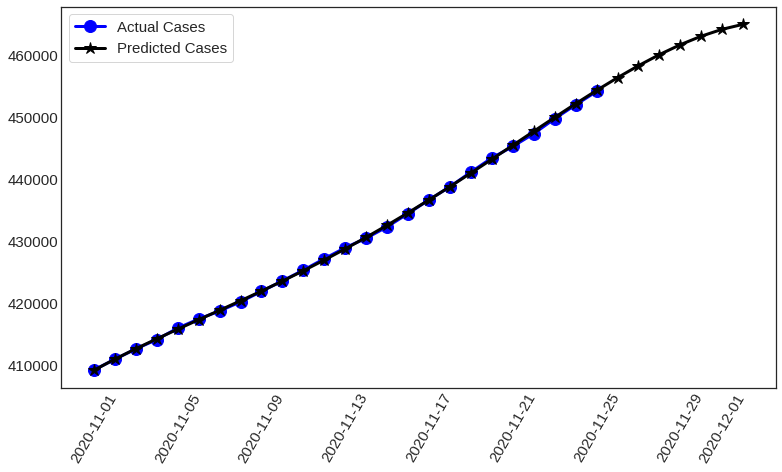

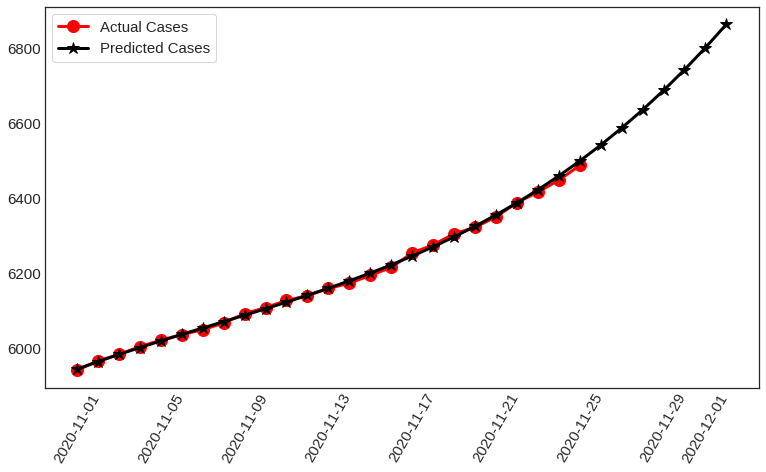

Execution Time: 0.4626207129999784


In [ ]:
t221 = time.process_time()

forecast_poly_lr_c, new_date_time_index_c, model_score_poly_c = PolyRegression_covid_19(4,train_ml["Confirmed"],valid_ml["Confirmed"],datewise_bd["Confirmed"],'Confirmed Cases')
forecast_poly_lr_d, new_date_time_index_d, model_score_poly_d = PolyRegression_covid_19(3,train_ml["Deaths"],valid_ml["Deaths"],datewise_bd["Deaths"],'Death Cases')

plt.figure(figsize=(12.8,7))
plot_result(datewise_bd["Confirmed"],new_date_time_index_c, forecast_poly_lr_c,'blue','Cases', 'Linear Regression')
#plot_result(datewise_bd["Deaths"],new_date_time_index_d, forecast_poly_lr_d,'red','Death Cases', 'Linear Regression') 
plt.xticks(rotation=60)
plt.legend(frameon=True)
plt.show() 

plt.figure(figsize=(12.8,7))
#plot_result(datewise_bd["Confirmed"],new_date_time_index_c, forecast_poly_lr_c,'blue','Confirmed Cases', 'Linear Regression')
plot_result(datewise_bd["Deaths"],new_date_time_index_d, forecast_poly_lr_d,'red','Cases', 'Linear Regression') 
plt.xticks(rotation=60)
plt.legend(frameon=True)
plt.show() 

elapsed_time_poly_lr = time.process_time() - t221

print("Execution Time:", elapsed_time_poly_lr)



Confirmed Cases
RMSE for Polynomial Regression:  [251.00273283900626]
Mean Absolute Error:  235.04014128351992
R2-Squared: 0.990178038178863


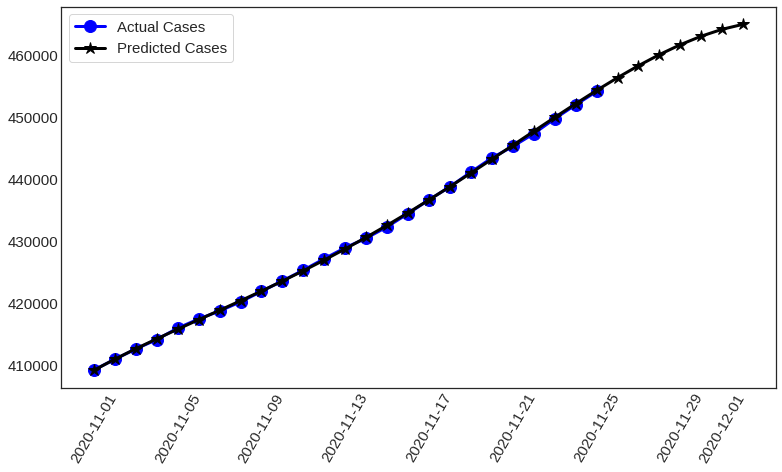

Execution Time: 0.26231401799998366


In [ ]:
t21 = time.process_time()
forecast_poly_lr_c, new_date_time_index_c, model_score_poly_c = PolyRegression_covid_19(4,train_ml["Confirmed"],valid_ml["Confirmed"],datewise_bd["Confirmed"],'Confirmed Cases')

plt.figure(figsize=(12.8,7))
plot_result(datewise_bd["Confirmed"],new_date_time_index_c, forecast_poly_lr_c,'blue','Cases', 'Linear Regression')
#plot_result(datewise_bd["Deaths"],new_date_time_index_d, forecast_poly_lr_d,'red','Death Cases', 'Linear Regression') 
plt.xticks(rotation=60)
plt.legend(frameon=True)
plt.show()

elapsed_time_poly_lr = time.process_time() - t21

print("Execution Time:", elapsed_time_poly_lr)

Death Cases
RMSE for Polynomial Regression:  [8.661519608164935]
Mean Absolute Error:  7.400664457586572
R2-Squared: 0.9448646938238018


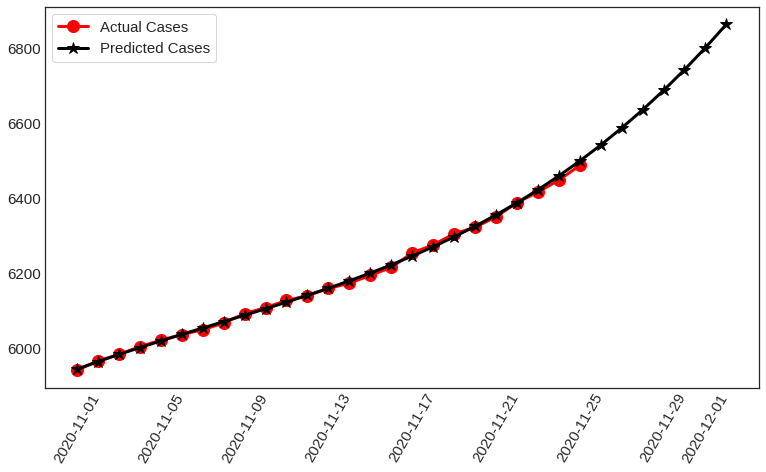

Execution Time: 0.22937371099999382


In [ ]:

t22 = time.process_time()

forecast_poly_lr_d, new_date_time_index_d, model_score_poly_d = PolyRegression_covid_19(3,train_ml["Deaths"],valid_ml["Deaths"],datewise_bd["Deaths"],'Death Cases')

plt.figure(figsize=(12.8,7))
#plot_result(datewise_bd["Confirmed"],new_date_time_index_c, forecast_poly_lr_c,'blue','Confirmed Cases', 'Linear Regression')
plot_result(datewise_bd["Deaths"],new_date_time_index_d, forecast_poly_lr_d,'red','Cases', 'Linear Regression') 
plt.xticks(rotation=60)
plt.legend(frameon=True)
plt.show() 

elapsed_time_poly_lr = time.process_time() - t22

print("Execution Time:", elapsed_time_poly_lr)

In [ ]:
interactive_graph(new_date_time_index_c,forecast_poly_lr_c,new_date_time_index_d,forecast_poly_lr_d)

In [ ]:
def SVRegression_covid_19(number_of_degree,train_d,valid_d,data_d,case):

    model_scores=[]

    svm=SVR(shrinking=True, kernel='poly',gamma=0.1, epsilon=0.1,degree=number_of_degree, C=10)
    svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_d).reshape(-1,1))
    
    prediction_valid_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
    model_scores.append(np.sqrt(mean_squared_error(valid_d,prediction_valid_svm)))
    print("RMSE for Support Vector Regression: ",model_scores)

    eval_reg(valid_d,prediction_valid_svm)
    

    prediction_svm=svm.predict(np.array(datewise_bd["Days Since"]).reshape(-1,1))

    #model_scores1=[]
    #model_scores1.append(np.sqrt(mean_squared_error(valid_d,prediction_svm[21:25])))
    #print("RMSE for SVM: ", model_scores1) 

    

    new_date=[]
    new_prediction_svm=[]

    for i in range(1,day):
        new_date.append(datewise_bd.index[-1]+timedelta(days=i))
        new_prediction_svm.append(svm.predict(np.array(datewise_bd["Days Since"].max()+i).reshape(-1,1))[0]) 
 

    forecast_svm, new_date_time_index =new_forecast(prediction_svm,new_prediction_svm,new_date)

    return (forecast_svm, new_date_time_index, model_scores)

RMSE for Support Vector Regression:  [15274.477876342491]
Mean Absolute Error:  14631.317470253707
R2-Squared: -35.37257845328438
RMSE for Support Vector Regression:  [36.310113657260345]
Mean Absolute Error:  35.331236557296506
R2-Squared: 0.031060141433529642


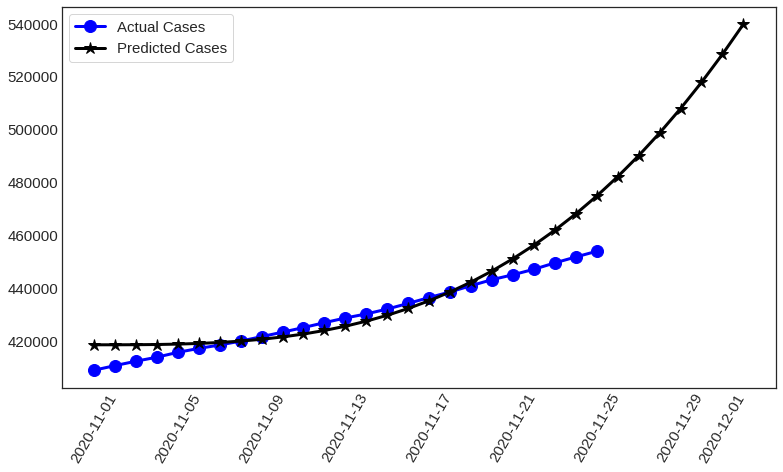

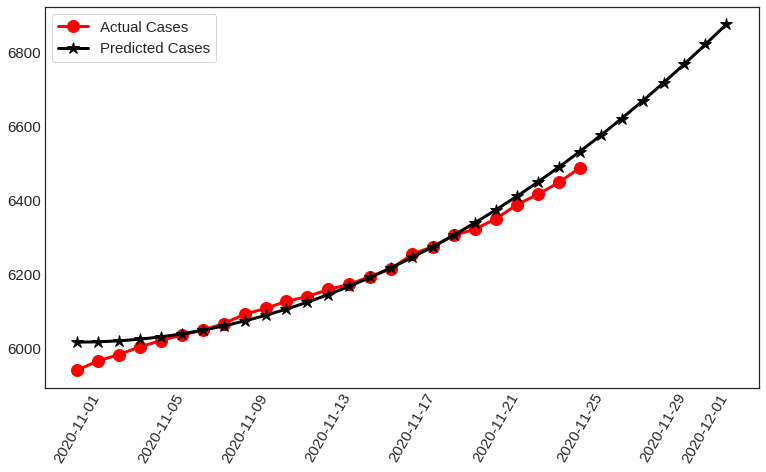

Execution Time 0.4765562830000363


In [ ]:
t3 = time.process_time()

forecast_svm_c, new_date_time_index_c, model_score_svm_c = SVRegression_covid_19(3,train_ml["Confirmed"],valid_ml["Confirmed"],datewise_bd["Confirmed"],'Confirmed Cases')
forecast_svm_d, new_date_time_index_d, model_score_svm_d = SVRegression_covid_19(2,train_ml["Deaths"],valid_ml["Deaths"],datewise_bd["Deaths"],'Deaths Cases')

plt.figure(figsize=(12.8,7))
plot_result(datewise_bd["Confirmed"],new_date_time_index_c, forecast_svm_c,'blue','Cases', 'Support Vector Regression')
#plot_result(datewise_bd["Deaths"],new_date_time_index_d, forecast_svm_d,'red','Cases', 'Support Vector Regression')
plt.xticks(rotation=60)
plt.legend(frameon=True) 
plt.show()

plt.figure(figsize=(12.8,7))
#plot_result(datewise_bd["Confirmed"],new_date_time_index_c, forecast_svm_c,'blue','Cases', 'Support Vector Regression')
plot_result(datewise_bd["Deaths"],new_date_time_index_d, forecast_svm_d,'red','Cases', 'Support Vector Regression')
plt.xticks(rotation=60)
plt.legend(frameon=True) 
plt.show()

elapsed_time_svm = time.process_time() - t3


print("Execution Time", elapsed_time_svm)

In [ ]:
interactive_graph(new_date_time_index_c,forecast_svm_c,new_date_time_index_d,forecast_svm_d)

In [ ]:
def MLPRegression_covid_19(train_d,valid_d,data_d,case):

    model_scores=[]

    #20,10,5 4th round death

    mlp=MLPRegressor(hidden_layer_sizes=[20,10,5], max_iter=50000, alpha=0.0005, random_state=26)  
    #mlp=MLPRegressor(hidden_layer_sizes=[100,], max_iter=20000, alpha=0.0005, random_state=10)
    mlp.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_d).reshape(-1,1))

    print(case)

    prediction_valid_mlp=mlp.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
    #print("Valid: ",prediction_valid_mlp)
    model_scores.append(np.sqrt(mean_squared_error(valid_d,prediction_valid_mlp)))
    print("RMSE for MLP: ",model_scores)

    eval_reg(valid_d,prediction_valid_mlp)
    
    prediction_mlp=mlp.predict(np.array(datewise_bd["Days Since"]).reshape(-1,1))
    #print("All :",prediction_mlp[21:25])

    #model_scores1=[]
    #model_scores1.append(np.sqrt(mean_squared_error(valid_d,prediction_mlp[21:25])))
    #print("RMSE for PR: ", model_scores1) 
    

    new_date=[]
    new_prediction_mlp=[]

    for i in range(1,day):
        new_date.append(datewise_bd.index[-1]+timedelta(days=i))
        new_prediction_mlp.append(mlp.predict(np.array(datewise_bd["Days Since"].max()+i).reshape(-1,1))[0]) 

    forecast_mlp, new_date_time_index =new_forecast(prediction_mlp,new_prediction_mlp,new_date)
    
    #plot_result(data_d,new_date_time_index, forecast_mlp,'blue', case, 'Multi Layer Perception Prediction')

    return (forecast_mlp, new_date_time_index, model_scores)


Confirmed Cases
RMSE for MLP:  [1487.7939133975801]
Mean Absolute Error:  1282.635746811662
R2-Squared: 0.6549143523569012


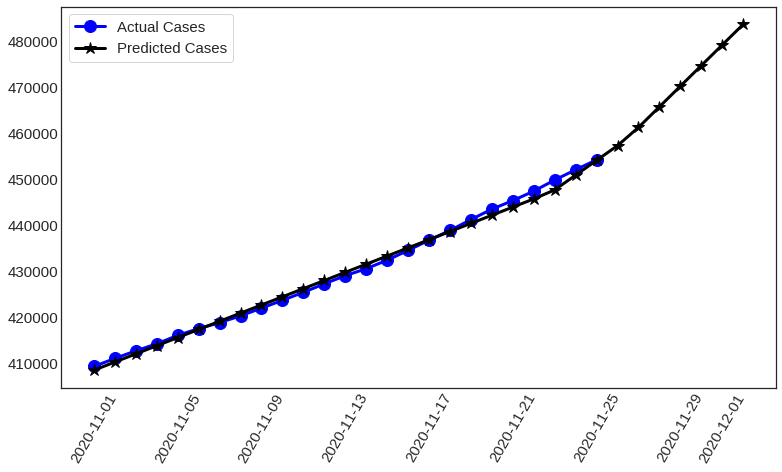

Execution Time 6.41800002399998


In [ ]:
t41 = time.process_time()

forecast_mlp_c, new_date_time_index_c, model_score_mlp_c = MLPRegression_covid_19(train_ml["Confirmed"],valid_ml["Confirmed"],datewise_bd["Confirmed"],'Confirmed Cases')


plt.figure(figsize=(12.8,7))
plot_result(datewise_bd["Confirmed"],new_date_time_index_c, forecast_mlp_c,'blue','Cases', 'MLP Regression')
#plot_result(datewise_bd["Deaths"],new_date_time_index_d, forecast_mlp_d,'red','Death Cases', 'MLP Regression')
plt.xticks(rotation=60)
plt.legend(frameon=True)
plt.show() 

elapsed_time_mlp = time.process_time() - t41
print("Execution Time", elapsed_time_mlp)

Death Cases
RMSE for MLP:  [399.81908696117443]
Mean Absolute Error:  359.4253196658101
R2-Squared: -116.48127494260598


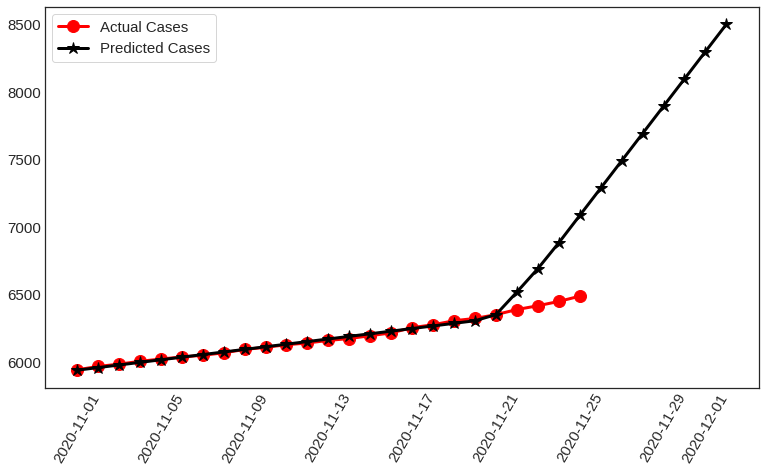

Execution Time 2.6250483309999595


In [ ]:
t42 = time.process_time()

forecast_mlp_d, new_date_time_index_d, model_score_mlp_d = MLPRegression_covid_19(train_ml["Deaths"],valid_ml["Deaths"],datewise_bd["Deaths"],'Death Cases')

plt.figure(figsize=(12.8,7))
#plot_result(datewise_bd["Confirmed"],new_date_time_index_c, forecast_mlp_c,'blue','Confirmed Cases', 'MLP Regression')
plot_result(datewise_bd["Deaths"],new_date_time_index_d, forecast_mlp_d,'red','Cases', 'MLP Regression')
plt.xticks(rotation=60)
plt.legend(frameon=True)
plt.show()

elapsed_time_mlp = time.process_time() - t42
print("Execution Time", elapsed_time_mlp)

In [ ]:
interactive_graph(new_date_time_index_c,forecast_mlp_c,new_date_time_index_d,forecast_mlp_d)

In [ ]:
def PolyMLPRegression_covid_19(number_of_degree,train_d,valid_d,data_d,case):

    poly = PolynomialFeatures(degree=number_of_degree)
    poly_train_ml = poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
    poly_valid_ml = poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
    poly_datewise_ml = poly.fit_transform(np.array(datewise_bd["Days Since"]).reshape(-1,1))

    model_scores=[]

    #25,13,5
    #20,10,5
    
    print(case)

    mlp=MLPRegressor(hidden_layer_sizes=[25,13,5], max_iter=50000, alpha=0.0005, random_state=26)
    #mlp=MLPRegressor(hidden_layer_sizes=[100,], max_iter=50000, alpha=0.0005, random_state=26)
    mlp.fit(poly_train_ml,np.array(train_d).reshape(-1,1))
    prediction_valid_mlp = mlp.predict(poly_valid_ml)
    model_scores.append(np.sqrt(mean_squared_error(valid_d,prediction_valid_mlp)))
    print("RMSE for Poly-MLP: ",model_scores)

    eval_reg(valid_d,prediction_valid_mlp)
    
    prediction_mlp=mlp.predict(poly_datewise_ml)

    #model_scores1=[]
    #model_scores1.append(np.sqrt(mean_squared_error(valid_d,prediction_mlp[21:25])))
    #print("RMSE for PR: ", model_scores1) 

    new_date=[]
    new_prediction_mlp=[]

    for i in range(1,day):
       new_date.append(datewise_bd.index[-1]+timedelta(days=i))
       poly_c=poly.fit_transform(np.array(datewise_bd["Days Since"].max()+i).reshape(-1,1))
       new_prediction_mlp.append(mlp.predict(poly_c)[0]) 

    forecast_mlp, new_date_time_index =new_forecast(prediction_mlp,new_prediction_mlp,new_date)

    #plot_result(data_d,new_date_time_index, forecast_mlp, 'blue', case, 'Poly Multi Layer Perception Prediction')

    return (forecast_mlp, new_date_time_index,model_scores)

Confirmed Cases
RMSE for Poly-MLP:  [2562.9212029970995]
Mean Absolute Error:  2502.225182095339
R2-Squared: -0.024028042480544798


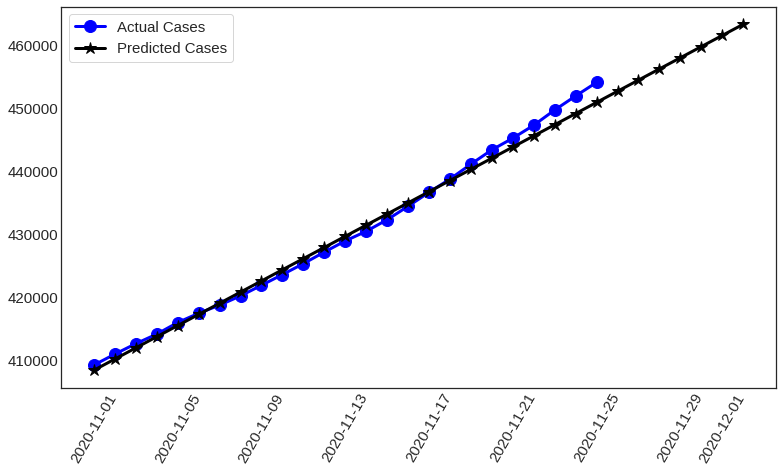

Execution Time 5.446693395000011


In [ ]:
t51 = time.process_time()

forecast_polymlp_c, new_date_time_index_c, model_score_polymlp_c = PolyMLPRegression_covid_19(1,train_ml["Confirmed"],valid_ml["Confirmed"],datewise_bd["Confirmed"],'Confirmed Cases')

plt.figure(figsize=(12.8,7))
plot_result(datewise_bd["Confirmed"],new_date_time_index_c, forecast_polymlp_c,'blue','Cases', 'PolyMLP Regression')
#plot_result(datewise_bd["Deaths"],new_date_time_index_d, forecast_polymlp_d,'red','Death Cases', 'PolyMLP Regression')
plt.xticks(rotation=60)
plt.legend(frameon=True) 
plt.show()

elapsed_time_polymlp = time.process_time() - t51
print("Execution Time", elapsed_time_polymlp)



Death Cases
RMSE for Poly-MLP:  [410.1035250274945]
Mean Absolute Error:  372.2657234926223
R2-Squared: -122.60288548250558


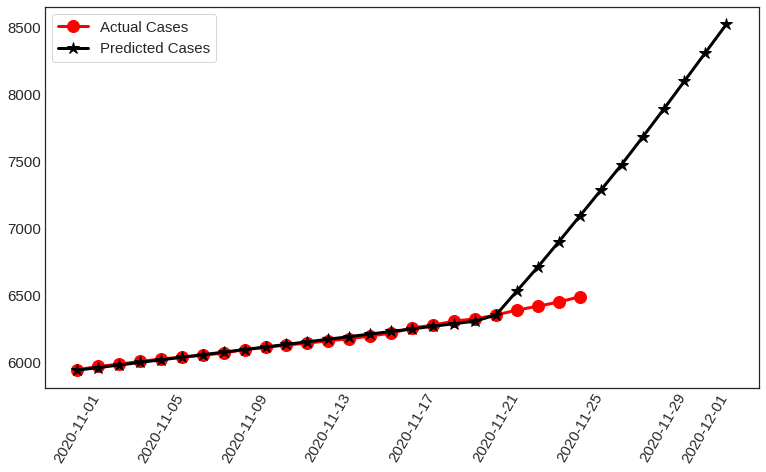

Execution Time 2.4008586840000135


In [ ]:
t52 = time.process_time()

forecast_polymlp_d, new_date_time_index_d, model_score_polymlp_d = PolyMLPRegression_covid_19(1,train_ml["Deaths"],valid_ml["Deaths"],datewise_bd["Deaths"],'Death Cases')

plt.figure(figsize=(12.8,7))
#plot_result(datewise_bd["Confirmed"],new_date_time_index_c, forecast_polymlp_c,'blue','Confirmed Cases', 'PolyMLP Regression')
plot_result(datewise_bd["Deaths"],new_date_time_index_d, forecast_polymlp_d,'red','Cases', 'PolyMLP Regression')
plt.xticks(rotation=60)
plt.legend(frameon=True) 
plt.show()

elapsed_time_polymlp = time.process_time() - t52
print("Execution Time", elapsed_time_polymlp)

In [ ]:
interactive_graph(new_date_time_index_c,forecast_polymlp_c,new_date_time_index_d,forecast_polymlp_d)

In [ ]:
from fbprophet.diagnostics import performance_metrics

In [ ]:
pjme_train=train_ml["Confirmed"]
pjme_train=pd.DataFrame(zip(list(train_ml["Days Since"].index),list(train_ml["Confirmed"])),columns=['ds','y'])

model = Prophet()
model.fit(pjme_train)

pjme_test=valid_ml['Confirmed']

pjme_test_fcst = model.predict(df=pjme_test.reset_index().rename(columns={'Date':'ds'}))
pjme_test_fcst['yhat']
#model.fit(prophet1)
#pjme_test_fcst = model.predict(df=valid_ml['Confirmed'])
#pjme_test_fcst.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


0   447259.751277
1   449127.741393
2   451339.741393
3   453450.741393
Name: yhat, dtype: float64

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


Confirmed Case
RMSE for Prophet Model:  [5.0409313045933295e-11, 3.681375715146283e-11]
Mean Absolute Error:  4.3655745685100555e-11
R2-Squared: 1.0
Deaths Case
RMSE for Prophet Model:  [6.641958296992261e-11, 1.203591076984524e-10]
Mean Absolute Error:  6.298250809777528e-11
R2-Squared: 1.0
Execution Time 27.632423077


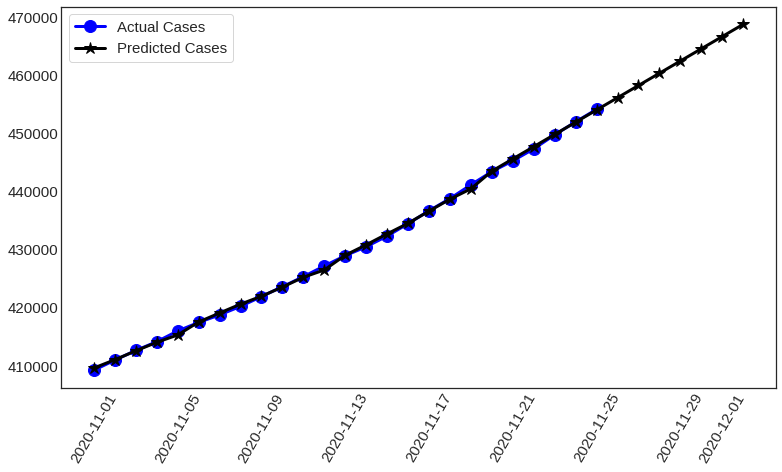

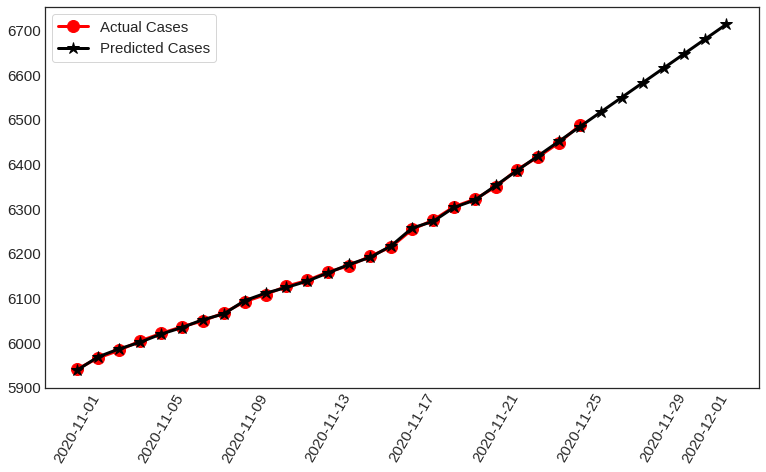

In [ ]:
t6 = time.process_time()
p=day-1
m=Prophet()

#prophet=pd.DataFrame(zip(list(train_ml["Days Since"].index),list(train_ml["Confirmed"])),columns=['ds','y'])
prophet=pd.DataFrame(zip(list(datewise_bd["Days Since"].index),list(datewise_bd["Confirmed"])),columns=['ds','y'])
m.fit(prophet)
future=m.make_future_dataframe(periods=p)
forecast=m.predict(future)

print('Confirmed Case')

model_score_prophet_c=[]
#model_score_prophet_c.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],forecast['yhat'][18:25])))
model_score_prophet_c.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],forecast['yhat'][21:25])))
model_score_prophet_c.append(np.sqrt(mean_squared_error(datewise_bd["Confirmed"],forecast['yhat'].head(datewise_bd.shape[0]))))
print("RMSE for Prophet Model: ", model_score_prophet_c)

eval_reg(valid_ml["Confirmed"],forecast['yhat'][21:25])
#eval_reg(valid_ml["Confirmed"],forecast['yhat'][18:25])
#eval_reg(datewise_bd["Confirmed"],forecast['yhat'].head(datewise_bd.shape[0]))

#cnfm_p = performance_metrics(forecast) 
#print(cnfm_p)

cnfrm = forecast.loc[:,['ds','trend']]
#cnfrm = cnfrm[cnfrm['trend']>0]
cnfrm.columns = ['Date','Confirm']

m2=Prophet() 

prophet_dth=pd.DataFrame(zip(list(datewise_bd["Days Since"].index),list(datewise_bd["Deaths"])),columns=['ds','y'])
m2.fit(prophet_dth)
future_dth=m2.make_future_dataframe(periods=p)
forecast_dth=m2.predict(future_dth)

print('Deaths Case')

model_score_prophet_d=[]
#model_score_prophet_d.append(np.sqrt(mean_squared_error(valid_ml["Deaths"],forecast_dth['yhat'][18:25])))
model_score_prophet_d.append(np.sqrt(mean_squared_error(valid_ml["Deaths"],forecast_dth['yhat'][21:25])))
model_score_prophet_d.append(np.sqrt(mean_squared_error(datewise_bd["Deaths"],forecast_dth['yhat'].head(datewise_bd.shape[0]))))
print("RMSE for Prophet Model: ",model_score_prophet_d)


#eval_reg(valid_ml["Deaths"],forecast_dth['yhat'][18:25])
eval_reg(valid_ml["Deaths"],forecast_dth['yhat'][21:25])
#eval_reg(datewise_bd["Deaths"],forecast_dth['yhat'].head(datewise_bd.shape[0]))

#dth_p = performance_metrics(forecast_dth) 
#print(dth_p)


dth = forecast_dth.loc[:,['ds','trend']]
#dth = dth[dth['trend']>0]
dth.columns = ['Date','Death']


plt.figure(figsize=(12.8,7))
plot_result(datewise_bd["Confirmed"],cnfrm['Date'],cnfrm['Confirm'],'blue','Cases', 'Prophet Regression')
#plot_result(datewise_bd["Deaths"],dth['Date'], dth['Death'],'red','Death Cases', 'Prophet Regression')
plt.xticks(rotation=60)
plt.legend(frameon=True)

plt.figure(figsize=(12.8,7))
#plot_result(datewise_bd["Confirmed"],cnfrm['Date'],cnfrm['Confirm'],'blue','Confirmed Cases', 'Prophet Regression')
plot_result(datewise_bd["Deaths"],dth['Date'], dth['Death'],'red','Cases', 'Prophet Regression')
plt.xticks(rotation=60)
plt.legend(frameon=True)

elapsed_time_prophet = time.process_time() - t6

print("Execution Time", elapsed_time_prophet)

#interactive_graph(cnfrm['Date'],cnfrm['Confirm'],dth['Date'],dth['Death'])

In [ ]:
fig = px.line(datewise_bd, x=cnfrm['Date'], y=cnfrm['Confirm'])
fig.add_scatter(x=new_date_time_index_c, y=datewise_bd['Confirmed']) 
#fig.add_scatter(x=cnfrm['Date'], y=datewise_bd['Confirmed']) 
fig.show() 

fig1 = px.line(datewise_bd, x=dth['Date'], y=dth['Death'])
fig1.add_scatter(x=new_date_time_index_d, y=datewise_bd['Deaths']) 
#fig.add_scatter(x=cnfrm['Date'], y=datewise_bd['Confirmed']) 
fig1.show()

In [ ]:
print("RMSE for LR",(model_score_lm_c, model_score_lm_d))
print("RMSE for PR",(model_score_poly_c, model_score_poly_d))
print("RMSE for SVR",(model_score_svm_c, model_score_svm_d))
print("RMSE for MLP",(model_score_mlp_c, model_score_mlp_d))
print("RMSE for Poly-MLP",(model_score_polymlp_c, model_score_polymlp_d))
print("RMSE for Prophet",(model_score_prophet_c, model_score_prophet_d))

RMSE for LR ([2563.0521119750433], [58.769627727206796])
RMSE for PR ([251.00273283900626], [8.661519608164935])
RMSE for SVR ([15274.477876342491], [36.310113657260345])
RMSE for MLP ([1487.7939133975801], [399.81908696117443])
RMSE for Poly-MLP ([2562.9212029970995], [410.1035250274945])
RMSE for Prophet ([5.0409313045933295e-11, 3.681375715146283e-11], [6.641958296992261e-11, 1.203591076984524e-10])


In [ ]:
print("Time for LR",elapsed_time_lr)
print("Time for PR",elapsed_time_poly_lr)
print("Time for SVR",elapsed_time_svm)
print("Time for MLP",elapsed_time_mlp)
print("Time for Poly-MLP",elapsed_time_polymlp)
print("Time for Prophet",elapsed_time_prophet)

Time for LR 0.49984499600003574
Time for PR 0.22937371099999382
Time for SVR 0.4765562830000363
Time for MLP 2.6250483309999595
Time for Poly-MLP 2.4008586840000135
Time for Prophet 27.632423077


In [ ]:
def RandomForestRegression_covid_19(train_d,valid_d,data_d,case):

    model_scores=[]
  

    rf=RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=-1)
    rf.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_d).reshape(-1,1))
    
    prediction_valid_rf=rf.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
    model_scores.append(np.sqrt(mean_squared_error(valid_d,prediction_valid_rf)))
    print("RMSE for Random Forest Regression: ",model_scores)
    

    prediction_rf=rf.predict(np.array(datewise_bd["Days Since"]).reshape(-1,1))

    new_date=[]
    new_prediction_rf=[]

    for i in range(1,6):
        new_date.append(datewise_bd.index[-1]+timedelta(days=i))
        new_prediction_rf.append(rf.predict(np.array(datewise_bd["Days Since"].max()+i).reshape(-1,1))[0]) 
 
    forecast_rf, new_date_time_index =new_forecast(prediction_rf,new_prediction_rf,new_date)

    #plot_result(data_d,new_date_time_index, forecast_rf,'blue', case, 'Random Forest Regression Prediction')

In [ ]:
RandomForestRegression_covid_19(train_ml["Confirmed"],valid_ml["Confirmed"],datewise_bd["Confirmed"],'Confirmed Cases')
RandomForestRegression_covid_19(train_ml["Deaths"],valid_ml["Deaths"],datewise_bd["Deaths"],'Deaths Cases')

RMSE for Random Forest Regression:  [7175.575081483016]
RMSE for Random Forest Regression:  [106.45518822490492]


In [ ]:
def DecisionTreeRegression_covid_19(train_d,valid_d,data_d,case):

    model_scores=[]

    rf=DecisionTreeRegressor(random_state=1)
    rf.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_d).reshape(-1,1))
    
    prediction_valid_rf=rf.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
    model_scores.append(np.sqrt(mean_squared_error(valid_d,prediction_valid_rf)))
    print("RMSE for Decision Tree Regression: ",model_scores)
    

    prediction_rf=rf.predict(np.array(datewise_bd["Days Since"]).reshape(-1,1))

    new_date=[]
    new_prediction_rf=[]

    for i in range(1,6):
        new_date.append(datewise_bd.index[-1]+timedelta(days=i))
        new_prediction_rf.append(rf.predict(np.array(datewise_bd["Days Since"].max()+i).reshape(-1,1))[0]) 
 
    forecast_rf, new_date_time_index =new_forecast(prediction_rf,new_prediction_rf,new_date)

    #plot_result(data_d,new_date_time_index, forecast_rf,'blue', case, 'Decision Tree Regression Prediction')

In [ ]:
DecisionTreeRegression_covid_19(train_ml["Confirmed"],valid_ml["Confirmed"],datewise_bd["Confirmed"],'Confirmed Cases')
DecisionTreeRegression_covid_19(train_ml["Deaths"],valid_ml["Deaths"],datewise_bd["Deaths"],'Deaths Cases')

RMSE for Decision Tree Regression:  [6080.788332938419]
RMSE for Decision Tree Regression:  [92.42970301802337]


In [ ]:
def RidgeRegression_covid_19(aph,train_d,valid_d,data_d,case):

    model_scores=[]

    rf=Ridge(alpha=aph)
    rf.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_d).reshape(-1,1))
    
    prediction_valid_rf=rf.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
    model_scores.append(np.sqrt(mean_squared_error(valid_d,prediction_valid_rf)))
    print("RMSE for Ridge Regression Regression: ",model_scores)
    

    prediction_rf=rf.predict(np.array(datewise_bd["Days Since"]).reshape(-1,1))

    new_date=[]
    new_prediction_rf=[]

    for i in range(1,8):
        new_date.append(datewise_bd.index[-1]+timedelta(days=i))
        new_prediction_rf.append(rf.predict(np.array(datewise_bd["Days Since"].max()+i).reshape(-1,1))[0]) 
 
    forecast_rf, new_date_time_index =new_forecast(prediction_rf,new_prediction_rf,new_date)

    return (forecast_rf, new_date_time_index,model_scores)
    #plot_result(data_d,new_date_time_index, forecast_rf,'blue', case, 'Ridge Regression Regression Prediction')

RMSE for Ridge Regression Regression:  [3122.215619105384]
RMSE for Ridge Regression Regression:  [61.88531623946644]


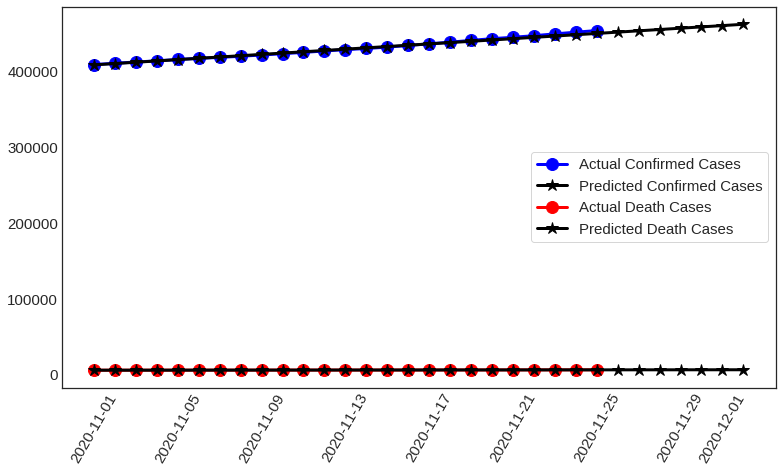

In [ ]:
forecast_rr_c, new_date_time_index_c, model_score_rr_c = RidgeRegression_covid_19(20,train_ml["Confirmed"],valid_ml["Confirmed"],datewise_bd["Confirmed"],'Confirmed Cases')
forecast_rr_d, new_date_time_index_d, model_score_rr_d = RidgeRegression_covid_19(10,train_ml["Deaths"],valid_ml["Deaths"],datewise_bd["Deaths"],'Deaths Cases')

plt.figure(figsize=(12.8,7))
plot_result(datewise_bd["Confirmed"],new_date_time_index_c, forecast_rr_c,'blue','Confirmed Cases', 'Linear Regression')
plot_result(datewise_bd["Deaths"],new_date_time_index_d, forecast_rr_d,'red','Death Cases', 'Linear Regression')
plt.xticks(rotation=60)
plt.legend(frameon=True) 
plt.show()

In [ ]:
interactive_graph(new_date_time_index_c,forecast_rr_c,new_date_time_index_d,forecast_rr_d)

In [ ]:
from sklearn import linear_model

def BayesianRidgeRegression_covid_19(train_d,valid_d,data_d,case):

    model_scores=[]

    rf=linear_model.BayesianRidge()
    rf.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_d).reshape(-1,1))
    
    prediction_valid_rf=rf.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
    model_scores.append(np.sqrt(mean_squared_error(valid_d,prediction_valid_rf)))
    print("RMSE for Bayesian Ridge Regression Regression: ",model_scores)
    #eval_reg(valid_d, prediction_valid_rf)

    prediction_rf=rf.predict(np.array(datewise_bd["Days Since"]).reshape(-1,1))

    new_date=[]
    new_prediction_rf=[]

    for i in range(1,6):
        new_date.append(datewise_bd.index[-1]+timedelta(days=i))
        new_prediction_rf.append(rf.predict(np.array(datewise_bd["Days Since"].max()+i).reshape(-1,1))[0]) 
 
    forecast_rf, new_date_time_index =new_forecast(prediction_rf,new_prediction_rf,new_date)

    return (forecast_rf, new_date_time_index,model_scores)

    #plot_result(data_d,new_date_time_index, forecast_rf,'blue', case, 'Bayesian Ridge Regression Regression Prediction')

RMSE for Bayesian Ridge Regression Regression:  [2568.5048581079523]
RMSE for Bayesian Ridge Regression Regression:  [58.87198714339741]


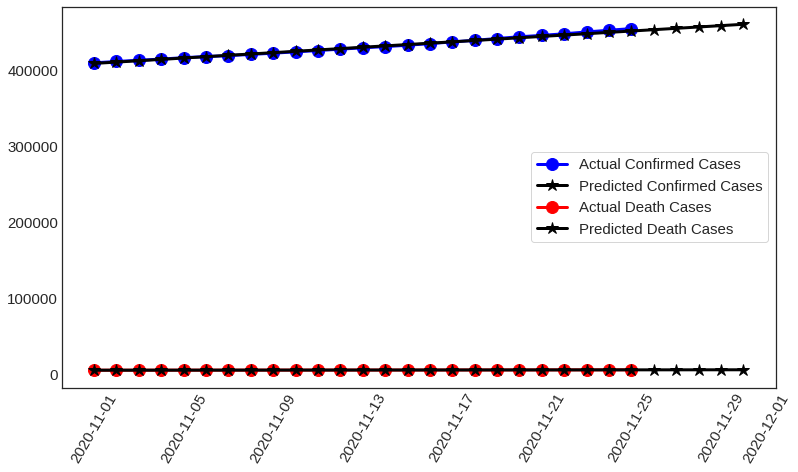

In [ ]:
forecast_brr_c, new_date_time_index_c, model_score_brr_c = BayesianRidgeRegression_covid_19(train_ml["Confirmed"],valid_ml["Confirmed"],datewise_bd["Confirmed"],'Confirmed Cases')
forecast_brr_d, new_date_time_index_d, model_score_brr_d = BayesianRidgeRegression_covid_19(train_ml["Deaths"],valid_ml["Deaths"],datewise_bd["Deaths"],'Deaths Cases')

plt.figure(figsize=(12.8,7))
plot_result(datewise_bd["Confirmed"],new_date_time_index_c, forecast_brr_c,'blue','Confirmed Cases', 'Linear Regression')
plot_result(datewise_bd["Deaths"],new_date_time_index_d, forecast_brr_d,'red','Death Cases', 'Linear Regression')
plt.xticks(rotation=60)
plt.legend(frameon=True) 
plt.show()

#BayesianRidgeRegression_covid_19(train_ml["Confirmed"],valid_ml["Confirmed"],datewise_bd["Confirmed"],'Confirmed Cases')
#BayesianRidgeRegression_covid_19(train_ml["Deaths"],valid_ml["Deaths"],datewise_bd["Deaths"],'Deaths Cases')